In [ ]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
df = pd.read_csv('/content/customer_data.csv').drop(['customerID'], axis=1)
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

## Visualization :

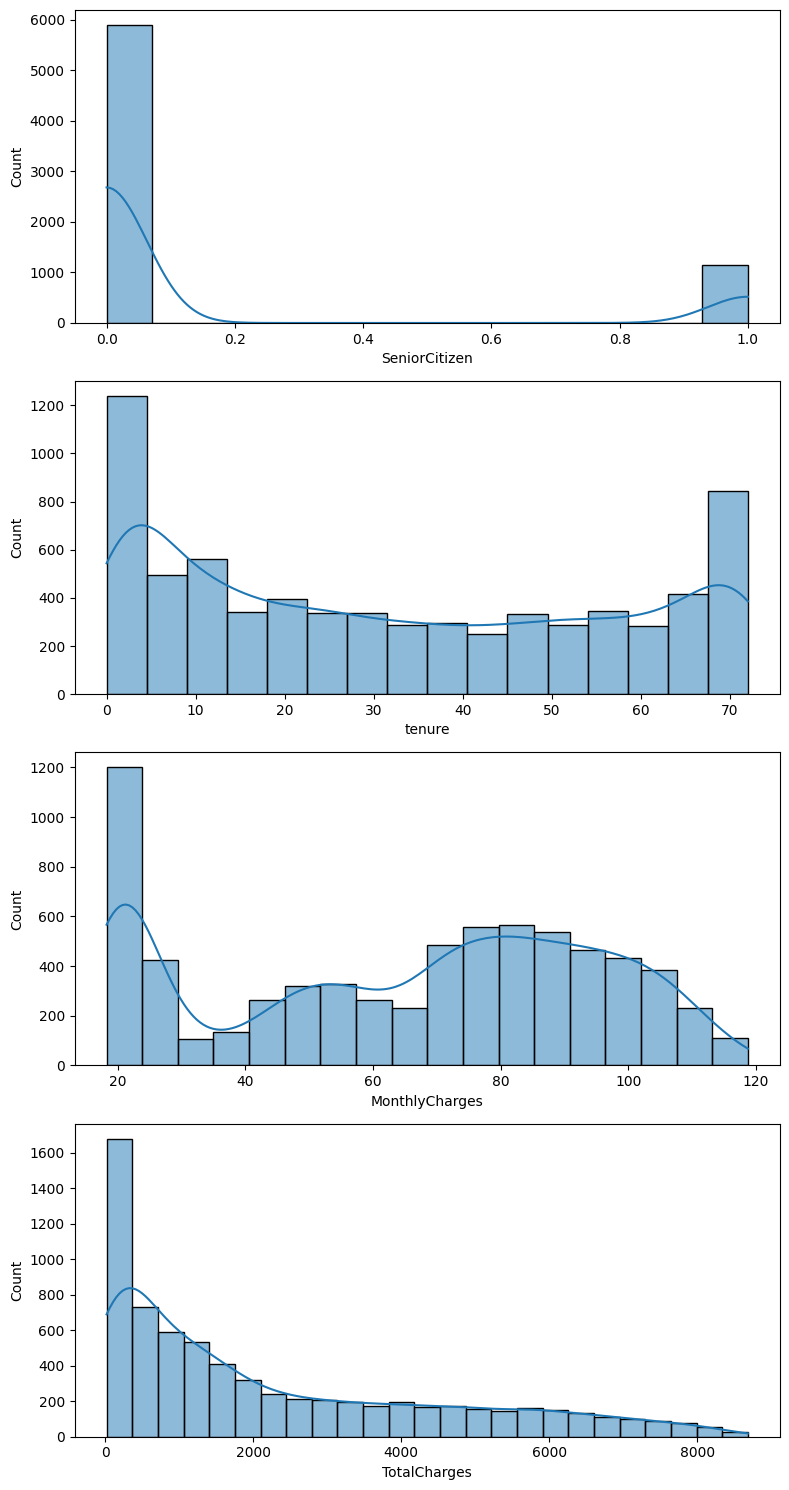

In [ ]:
# check the distributions (numerical)
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(8,15))

numerical_columns = df.select_dtypes(include=['number']).columns.to_list()

for i,column in enumerate(numerical_columns):
    plt.subplot(len(numerical_columns),1,i+1)
    sns.histplot(x=df[column],kde=True)
    plt.tight_layout()

In [ ]:
# column summary function
def column_summary(df):

    summary_df = pd.DataFrame({
        'col_dtype' : df.dtypes.values,
        'num_of_nulls' : df.isnull().sum().values,
        'null%' : round((df.isnull().sum()/df.shape[0])*100, 2).values,
        'num_of_non_nulls' : df.count().values,
        'num_of_distinct_values' : df.nunique().values
    }, index=df.columns)

    ## extracting distinct_values_counts for summary_df
    distinct_values_counts = []
    for i in range(df.shape[1]):
        if summary_df['num_of_distinct_values'][i]<=10:
            distinct_values_counts.append(dict(zip(df[df.columns[i]].value_counts().index.to_list(),df[df.columns[i]].value_counts().values)))
        else:
            distinct_values_counts.append(dict(zip(df[df.columns[i]].value_counts().index.to_list()[:10],df[df.columns[i]].value_counts().values[:10])))

    summary_df['distinct_values_counts'] = distinct_values_counts

    return summary_df

summary = column_summary(df)
summary

,col_dtype,num_of_nulls,null%,num_of_non_nulls,num_of_distinct_values,distinct_values_counts
gender,object,0,0.00,7043,2,"{'Male': 3555, 'Female': 3488}"
SeniorCitizen,int64,0,0.00,7043,2,"{0: 5901, 1: 1142}"
Partner,object,0,0.00,7043,2,"{'No': 3641, 'Yes': 3402}"
Dependents,object,0,0.00,7043,2,"{'No': 4933, 'Yes': 2110}"
tenure,int64,0,0.00,7043,73,"{1: 613, 72: 362, 2: 238, 3: 200, 4: 176, 71: ..."
PhoneService,object,0,0.00,7043,2,"{'Yes': 6361, 'No': 682}"
MultipleLines,object,0,0.00,7043,3,"{'No': 3390, 'Yes': 2971, 'No phone service': ..."
InternetService,object,0,0.00,7043,3,"{'Fiber optic': 3096, 'DSL': 2421, 'No': 1526}"
OnlineSecurity,object,0,0.00,7043,3,"{'No': 3498, 'Yes': 2019, 'No internet service..."
OnlineBackup,object,0,0.00,7043,3,"{'No': 3088, 'Yes': 2429, 'No internet service..."


## Handle Missing Values :

In [ ]:
df['TotalCharges'].isnull().sum()

11

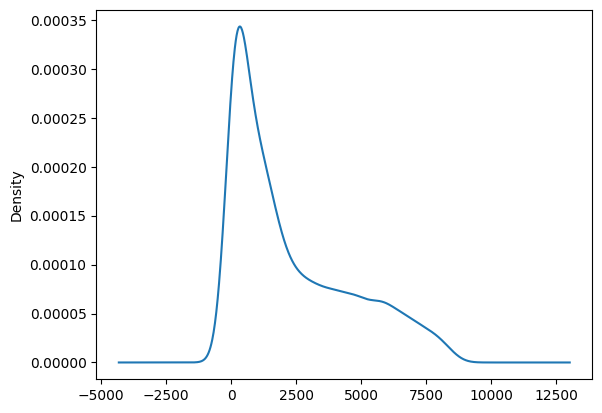

In [ ]:
# filling the null values
df['TotalCharges'].plot(kind='kde')

fill_value = df['TotalCharges'].mean()
df['TotalCharges'] = df['TotalCharges'].fillna(fill_value)

In [ ]:
summary = column_summary(df)
summary

,col_dtype,num_of_nulls,null%,num_of_non_nulls,num_of_distinct_values,distinct_values_counts
gender,object,0,0.0,7043,2,"{'Male': 3555, 'Female': 3488}"
SeniorCitizen,int64,0,0.0,7043,2,"{0: 5901, 1: 1142}"
Partner,object,0,0.0,7043,2,"{'No': 3641, 'Yes': 3402}"
Dependents,object,0,0.0,7043,2,"{'No': 4933, 'Yes': 2110}"
tenure,int64,0,0.0,7043,73,"{1: 613, 72: 362, 2: 238, 3: 200, 4: 176, 71: ..."
PhoneService,object,0,0.0,7043,2,"{'Yes': 6361, 'No': 682}"
MultipleLines,object,0,0.0,7043,3,"{'No': 3390, 'Yes': 2971, 'No phone service': ..."
InternetService,object,0,0.0,7043,3,"{'Fiber optic': 3096, 'DSL': 2421, 'No': 1526}"
OnlineSecurity,object,0,0.0,7043,3,"{'No': 3498, 'Yes': 2019, 'No internet service..."
OnlineBackup,object,0,0.0,7043,3,"{'No': 3088, 'Yes': 2429, 'No internet service..."


## Handle Categorical Columns :

In [ ]:
categorical_columns = summary[summary['col_dtype'] == 'object'].iloc[:-1].index    # --> excluding target column
df = pd.get_dummies(df, columns=categorical_columns, dtype=np.int64, drop_first=True)

In [ ]:
# handling categories for the target column
df['Churn'] = df['Churn'].map({'Yes':1, 'No':0})

## Train Test Split :

In [ ]:
X = df.drop(['Churn'], axis=1)
y = df['Churn']

# split with 20% test data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

## Model Training :

#### 1. Logistic Regression --

In [ ]:
clf = LogisticRegression()

clf.fit(X_train, y_train)

# evaluation
y_pred = clf.predict(X_test)

print(f'R2 : {accuracy_score(y_test, y_pred)}')
print(f'MAE : {precision_score(y_test, y_pred)}')
print(f'MSE : {recall_score(y_test, y_pred)}')

R2 : 0.8183108587650816
MAE : 0.6943521594684385
MSE : 0.5603217158176944


#### 2. Random Forest Classifier --

In [ ]:
clf = RandomForestClassifier()

clf.fit(X_train, y_train)

# evaluation
y_pred = clf.predict(X_test)

print(f'R2 : {accuracy_score(y_test, y_pred)}')
print(f'MAE : {precision_score(y_test, y_pred)}')
print(f'MSE : {recall_score(y_test, y_pred)}')

R2 : 0.7913413768630234
MAE : 0.6446886446886447
MSE : 0.4718498659517426


#### 3. XGBoost --

In [ ]:
clf = xgb.XGBClassifier()

clf.fit(X_train, y_train)

# evaluation
y_pred = clf.predict(X_test)

print(f'R2 : {accuracy_score(y_test, y_pred)}')
print(f'MAE : {precision_score(y_test, y_pred)}')
print(f'MSE : {recall_score(y_test, y_pred)}')

R2 : 0.78708303761533
MAE : 0.6212624584717608
MSE : 0.5013404825737265


## Model Evaluation :

In [ ]:
# Final Model as Logistic Regression

print(f'R2 : {accuracy_score(y_test, y_pred)}')
print(f'MAE : {precision_score(y_test, y_pred)}')
print(f'MSE : {recall_score(y_test, y_pred)}')

R2 : 0.8183108587650816
MAE : 0.6943521594684385
MSE : 0.5603217158176944
